In [1]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/P-B/Data
import tensorflow as tf
import tensorflow.keras.layers as layers
from tensorflow.keras.models import Model,Sequential
import tensorflow.keras.regularizers as regularizers
from tensorflow.keras.utils import plot_model
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
import numpy as np
import pathlib
import os
import PIL
import datetime

Mounted at /content/drive
/content/drive/MyDrive/P-B/Data


In [2]:
dataset_url = "/content/drive/MyDrive/P-B/Data"
data_dir = pathlib.Path(dataset_url)
print(data_dir)


/content/drive/MyDrive/P-B/Data


In [3]:
image_count = len(list(data_dir.glob('*/*.jpg')))
print(image_count)

3792


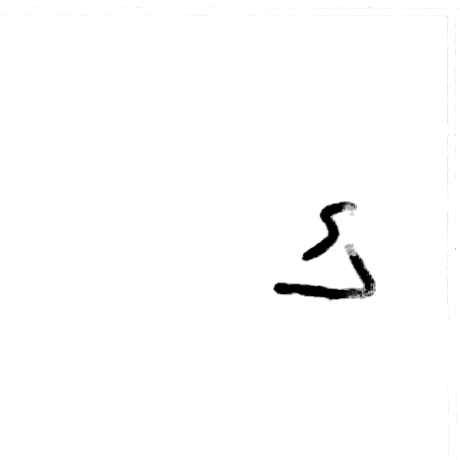

In [4]:
chars01 = list(data_dir.glob('01/*'))
PIL.Image.open(str(chars01[1]))

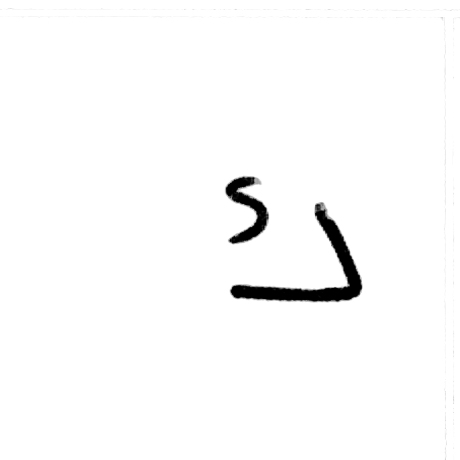

In [5]:
PIL.Image.open(str(chars01[0]))

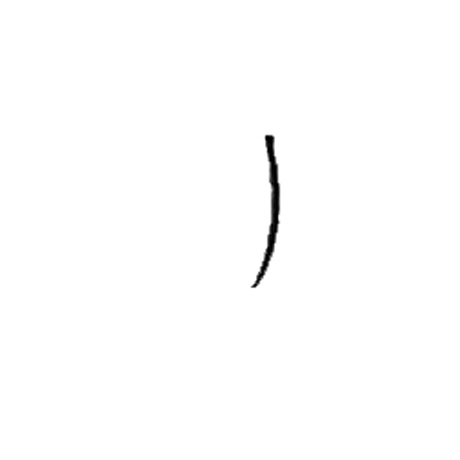

In [6]:
chars02 = list(data_dir.glob('02/*'))
PIL.Image.open(str(chars02[0]))

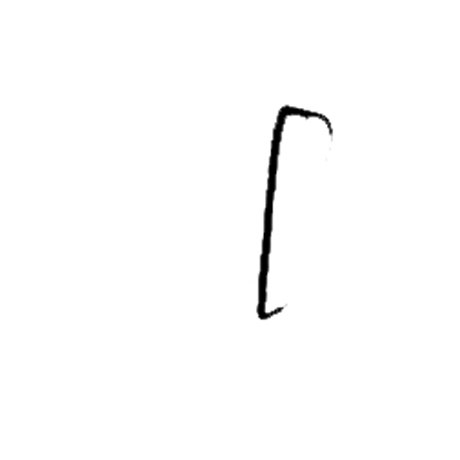

In [7]:
PIL.Image.open(str(chars02[1]))

In [8]:
batch_size = 32
img_height = 180
img_width = 180

In [9]:
train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3792 files belonging to 36 classes.
Using 3034 files for training.


In [10]:
val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 3792 files belonging to 36 classes.
Using 758 files for validation.


In [11]:
class_names = train_ds.class_names
print(class_names)

['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', 'logs']


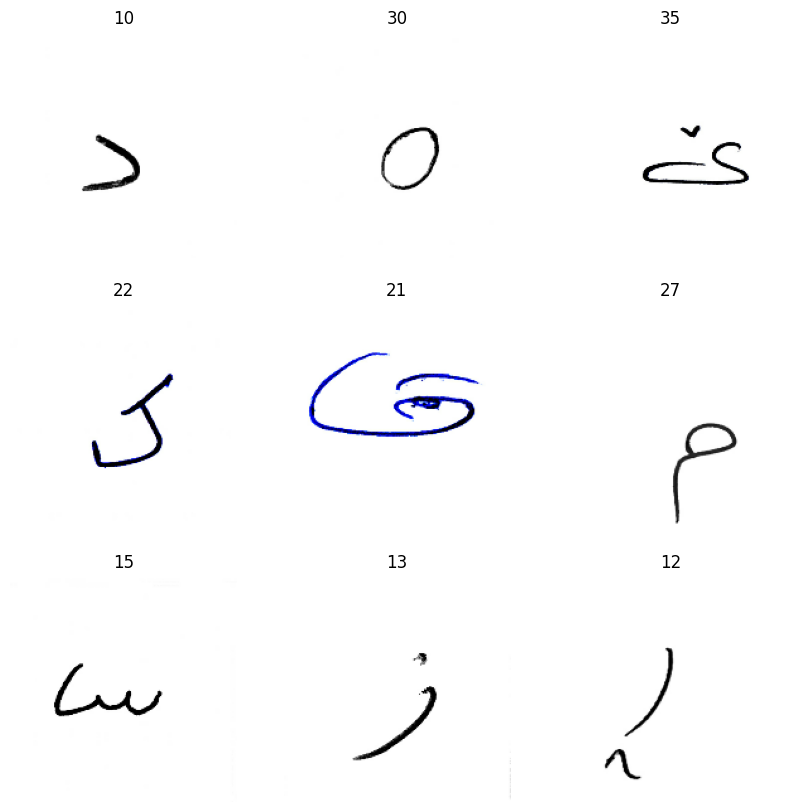

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [13]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [14]:
normalization_layer = tf.keras.layers.Rescaling(1./255)

In [15]:
normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

0.0 1.0


In [16]:
# Load the pre-trained ResNet50 model (excluding the top fully connected layers)
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_height, img_width, 3))

# Freeze the pre-trained layers so they are not updated during training
for layer in base_model.layers:
    layer.trainable = False

# Create a new model and add the pre-trained base on top of it
num_classes = len(class_names)
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

94765736/94765736 [==============================] - 5s 0us/step


In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 6, 6, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 36)                4644      
                                                                 
Total params: 23,854,628
Trainable params: 266,916
Non-trainable params: 23,587,712
_________________________________________________________________


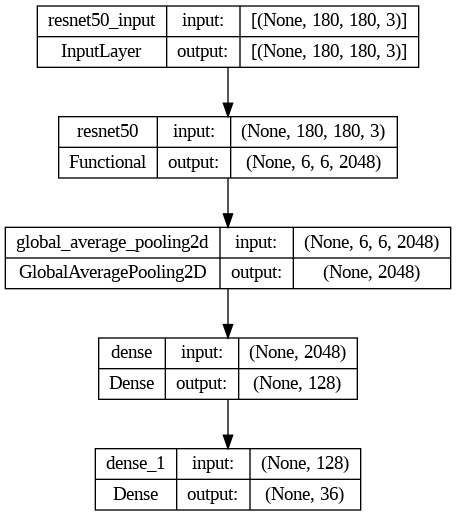

In [18]:
plot_model(model, show_shapes=True)

In [19]:
with tf.device("/gpu:0"):
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
                metrics=['accuracy'])

In [20]:
epochs=30
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
es_callback = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)

history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  callbacks=[es_callback,tensorboard_callback]
)

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/backend.py:5612: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


95/95 [==============================] - 292s 3s/step - loss: 2.5402 - accuracy: 0.3349 - val_loss: 1.7280 - val_accuracy: 0.5396
Epoch 2/30
95/95 [==============================] - 16s 171ms/step - loss: 1.3966 - accuracy: 0.6183 - val_loss: 1.2518 - val_accuracy: 0.6412
Epoch 3/30
95/95 [==============================] - 16s 164ms/step - loss: 1.0057 - accuracy: 0.7175 - val_loss: 1.0086 - val_accuracy: 0.7203
Epoch 4/30
95/95 [==============================] - 16s 168ms/step - loss: 0.7881 - accuracy: 0.7821 - val_loss: 0.8591 - val_accuracy: 0.7507
Epoch 5/30
95/95 [==============================] - 16s 168ms/step - loss: 0.6290 - accuracy: 0.8329 - val_loss: 0.7648 - val_accuracy: 0.7599
Epoch 6/30
95/95 [==============================] - 15s 159ms/step - loss: 0.5245 - accuracy: 0.8603 - val_loss: 0.6861 - val_accuracy: 0.8100
Epoch 7/30
95/95 [==============================] - 15s 160ms/step - loss: 0.4472 - accuracy: 0.8787 - val_loss: 0.6924 - val_accuracy: 0.7995
Epoch 8/30
9

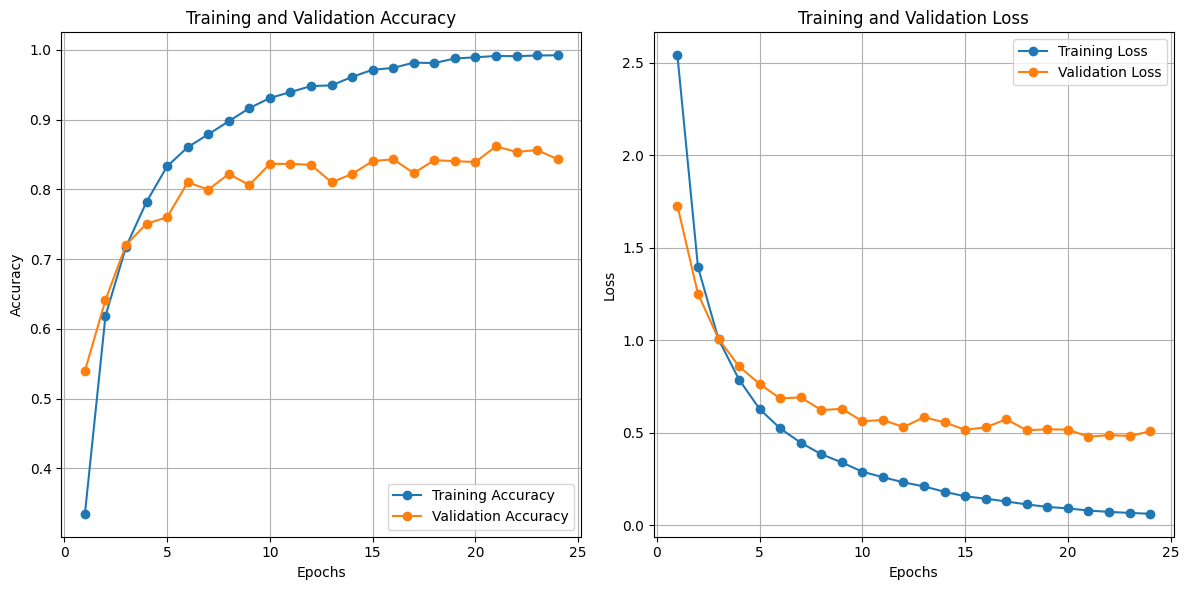

In [22]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(acc) + 1)  # Update epochs_range to match the length of acc

plt.figure(figsize=(12, 6))

# Plotting Training and Validation Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, marker='o', label='Training Accuracy')
plt.plot(epochs_range, val_acc, marker='o', label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.grid(True)

# Plotting Training and Validation Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, marker='o', label='Training Loss')
plt.plot(epochs_range, val_loss, marker='o', label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.grid(True)

plt.tight_layout()  # Adjust spacing between subplots

plt.show()